# Data Visualization and Prediction with Python
 

In [1]:
import csv
import numpy as np
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt


## Data Formation and Parsing
Using the csv and datetime packages, we reformat the given data into proper datetime format and sort it time.

In [2]:
def get_all_cases():
    with open("info/covid19dataexport.csv", "r") as csvfile:
        reader = csv.reader(csvfile)
        all_cases = list(reader)[1:]
        # ignore the case numbers
        for i in range(len(all_cases)):
            all_cases[i] = all_cases[i][1:]
            year = int(all_cases[i][0].split('-')[0])
            month = int(all_cases[i][0].split('-')[1])
            day = int(all_cases[i][0].split('-')[2])
            formatted_date = datetime(year,month,day)
            all_cases[i][0] = formatted_date
        all_cases.sort()
        return all_cases

### Creating Cases per Day & Cases per Week
We store the data in a dictionary of {date: cases}. Other alternatives could be a list of lists, or two lists with the same length correlating to each other.

In [3]:
def get_per_day(all_cases: dict):
    case_per_day = dict()
    for case in all_cases:
        if case[0] in case_per_day:
            case_per_day[case[0]] +=1
        else:
            case_per_day[case[0]] = 1
    return case_per_day
def get_per_week(all_cases: dict):
    case_per_week = dict()
    # First case 3/06, week will start there. We will use a sliding timeframe to group these.
    # Therefore, the cases sums start at 3/13
    key = datetime(2020,3,13)
    for case in all_cases:
        while (case[0] >= key):
            key += timedelta(days=7)

        if key in case_per_week:
            case_per_week[key] +=1
        else:
            case_per_week[key] = 1
    return case_per_week


### Normal Average & Weighted Averages (bandits algorithm)
Here, we use a weighted average of the previous cases per day to predict the next upcoming day. 

In [4]:
def normal_ave(dct):
    n = 0
    ave = 0
    daily_ave = dict()
    for day in dct.keys():
        n+=1
        ave = ave + (1/n)*(dct[day]-ave)
        daily_ave[day] = ave
    return daily_ave
def weighted_ave(dct, ss):
    n = 0
    ave = 0
    daily_ave = dict()
    for day in dct.keys():
        n+=1
        ave = ave + (ss)*(dct[day]-ave)
        daily_ave[day] = ave
    return daily_ave

You can change the step size to affect how much new points of data affects our running weighted average. It should be between 0 and 1, exclusively. At a stepsize of 0, there is no change to the average. At a stepsize of 1, it follows the data perfectly.

As you can see, a normal running average is terrible for analysis. Spikes and changes in data barely affect the overall average. Using a constant step-size is a little better for modelling, as it follows the data closely. However, a weighted average does not give us much information about future predictions.

In [5]:
STEP_SIZE = 0.15

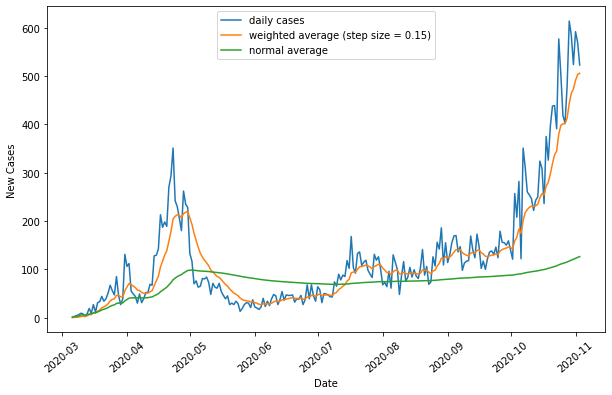

In [6]:
def plot_averages():
    all_cases = get_all_cases()
    pday = get_per_day(all_cases)
    m = normal_ave(pday)
    w = weighted_ave(pday, STEP_SIZE)
    plt.figure(figsize=(10,6))
    plt.ylabel('New Cases')
    plt.xticks(rotation=40)
    plt.xlabel('Date')

    plt.plot(pday.keys(), pday.values())
    plt.plot(w.keys(), w.values())
    plt.plot(m.keys(), m.values())
    plt.legend(["daily cases", "weighted average"+" (step size = %.2f)" %STEP_SIZE, "normal average"], loc=9)
    plt.show()
plot_averages()

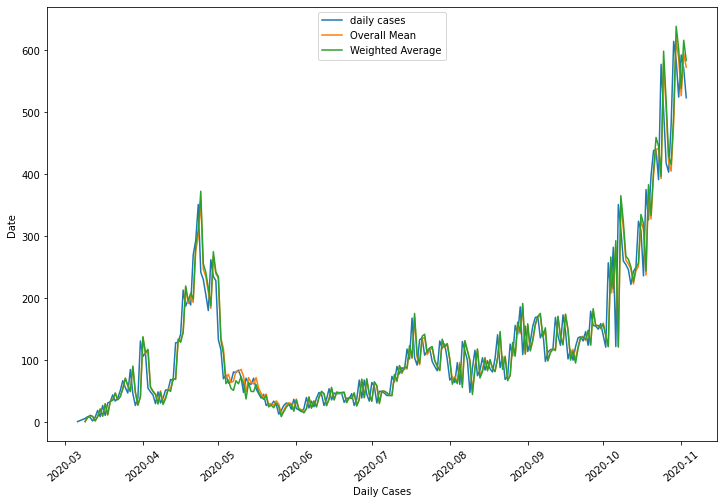

In [7]:
RECENT_DAYS = 15
all_cases = get_all_cases()
per_day = get_per_day(all_cases)
def overall_linear_prediction(pday, up2date):
    keys=sorted(pday.keys())
    while (up2date not in keys):
        up2date += timedelta(days=1)
    keys = keys[:keys.index(up2date)]
    day1,cases1 = keys[0], pday[keys[0]]
    daylatest,caseslatest = keys[-1], pday[keys[-1]]
    delta_time = (daylatest-day1).days
    delta_case = caseslatest-cases1
    if (delta_time == 0):
        return 0, caseslatest
    else:
        return delta_case/delta_time, caseslatest

def recent_linear_prediction(pday, up2date):
    
    keys=sorted(pday.keys())
    while (up2date not in keys):
        up2date += timedelta(days=1)
    keys = keys[:keys.index(up2date)]
    if (len(keys)>RECENT_DAYS):
        day_early,cases_early = keys[-1-RECENT_DAYS], pday[keys[-1-RECENT_DAYS]]
    else:
        day_early,cases_early = keys[0], pday[keys[0]]

    day_latest,cases_latest = keys[-1], pday[keys[-1]]
    delta_time = (day_latest-day_early).days
    delta_case = cases_latest-cases_early
    
    if (delta_time == 0):
        return 0, cases_latest
    else:
        return delta_case/delta_time, cases_latest

def plot_linear_predictions(per_day):
    # for any given day, we plot 
    all_cases = get_all_cases()
    per_day = get_per_day(all_cases)
    olp = []
    rlp = []
    prediction_list = list(per_day.keys())[1:]
    olp = [sum(overall_linear_prediction(per_day, d)) for d in prediction_list]
    rlp = [sum(recent_linear_prediction(per_day, d)) for d in prediction_list]
    plt.figure(figsize=(12,8))
    plt.ylabel('Date')
    plt.xticks(rotation=40)
    plt.xlabel('Daily Cases')
   
  
    
    plt.plot(per_day.keys(), per_day.values())
    plt.plot(sorted(per_day.keys())[1:], olp)
    plt.plot(sorted(per_day.keys())[1:], rlp)
    plt.legend(["daily cases", "Overall Mean", "Weighted Average"], loc=9)
    plt.show()
plot_linear_predictions(per_day)



IDK IF THIS IS CORRECT ^


### Monte Carlo
